# Boston Airbnb 2022 

* [Medium Post](http://insideairbnb.com/get-the-data/)

## Index

* [1. Introduction](#1)
* [2. Data Preparation](#2)
* [3. Exploratory Data Analysis](#3)
* [4. Conclusion](#4)

# Introduction <a class="anchor" id="1"></a>

Boston, Massachusetts is one of the most visited cities, more than 20 million passengers last year according to the [tuorism board statics](https://www.bostonusa.com/media/statistics-and-reports/). It’s no secret Boston is full of historic stories to tell, as well as soak up a great deal of street food and fun activites all day long. 

This post is aim to provide a basic sense of the rental supply with Airbnb in 2022, which will allow you to maximize the thrill of being there. This analysis is going to answer the following questions:

* **How much will cost if you plan to visit the city?**
* **Which kind of the room is more popular?**
* **What are the popular amenities in the room?**
* **Features importance**

All the raw data come from the [Inside Airbnb database](http://insideairbnb.com/) 2022.

### Load Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor


%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# calendar = pd.read_csv("calendar.csv")
listings = pd.read_csv("listings.csv")
# reviews = pd.read_csv("reviews.csv")

In [3]:
listings.shape

(4903, 74)

The whole listings has 4903 listings and 74  features. 

In [4]:
listings.head(2)

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,9569407.0,https://www.airbnb.com/rooms/9569407,2.022060e+13,6/13/22,Clean & Cozy Newton/Boston College,"Queen bed room in house near BC, near T statio...",NaN,https://a0.muscache.com/pictures/93cbba82-23be...,44920239,https://www.airbnb.com/users/show/44920239,...,5.0,4.92,4.77,NaN,f,2,0,2,0,0.17
1,31650137.0,https://www.airbnb.com/rooms/31650137,2.022060e+13,6/13/22,Cozy Queen Bedroom close to Boston,"Sunny room in a clean, quiet home. Very quiet ...","Many ethnic restaurants, shops and supermarket...",https://a0.muscache.com/pictures/253151c2-1432...,13005723,https://www.airbnb.com/users/show/13005723,...,5.0,4.84,4.92,NaN,t,3,0,3,0,3.60


# Data Preparation <a class="anchor" id="2"></a>

In [5]:
# take a look at the post information
post_1 = listings.query("id==9569407.0")
for col in list(listings.columns):
    print(col + " : " + str(post_1.loc[0, col]))

id : 9569407.0
listing_url : https://www.airbnb.com/rooms/9569407
scrape_id : 20220600000000.0
last_scraped : 6/13/22
name : Clean & Cozy Newton/Boston College
description : Queen bed room in house near BC, near T station (Newton Center/8 minutes walking)<br />Near restaurants, cafes, banks, parks, CVS, Panera Bread, pizzerias, bakery just across street<br /><br /><b>Other things to note</b><br />No use of stove, no cooking, no fry of any type, just use of microwave, toaster, hot water kettle, refrigerator.
neighborhood_overview : nan
picture_url : https://a0.muscache.com/pictures/93cbba82-23be-48e6-be5f-e6bd8c05ac07.jpg
host_id : 44920239
host_url : https://www.airbnb.com/users/show/44920239
host_name : Marcia
host_since : 9/23/15
host_location : Newton, Massachusetts, United States
host_about : I like to make new friends and travel
host_response_time : within a few hours
host_response_rate : 90%
host_acceptance_rate : 22%
host_is_superhost : f
host_thumbnail_url : https://a0.muscache

In [6]:
# check duplicates
listings[listings.duplicated()]

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month


In [7]:
#check empty columns
listings.columns[listings.isnull().sum()/listings.shape[0]==1]

Index(['neighbourhood_group_cleansed', 'bathrooms', 'calendar_updated'], dtype='object')

In [8]:
# drop empty columns
listings = listings.drop(columns=['neighbourhood_group_cleansed', 'bathrooms', 'calendar_updated'])

In [9]:
# convert price to numeric
listings['price'] = listings['price'].apply(lambda x: float(x.replace(",", "")[1:]) if x is not None else 0)

**Amenities cleanup**

Because of the descriptions of amentities are vary. I plan to extract the most frquently appearred words and create my own list of amentities.

In [10]:
# find out the word most frequently appeared in amenities
amenities_word = []
for i in listings.amenities:
    i = i.replace('[', '').replace(']', '').replace('"', '')
    for j in i.split(','): 
#         print(type(j))
        for w in j.split(' '):
           amenities_word.append(w.lower()) 

word_dict = {}
for i in list(set(amenities_word)):
    word_dict[i] = amenities_word.count(i)
word_dict = sorted(word_dict.items(), key=lambda item: item[1], reverse=True)
word_dict[:50]

[('', 137190),
 ('alarm', 9231),
 ('dryer', 7472),
 ('allowed', 5911),
 ('and', 5642),
 ('wifi', 4927),
 ('smoke', 4732),
 ('tv', 4687),
 ('hot', 4685),
 ('long', 4595),
 ('stays', 4595),
 ('term', 4595),
 ('water', 4586),
 ('heating', 4561),
 ('carbon', 4499),
 ('monoxide', 4499),
 ('essentials', 4483),
 ('kitchen', 4379),
 ('hangers', 4259),
 ('hair', 4085),
 ('iron', 4042),
 ('on', 4042),
 ('parking', 3952),
 ('air', 3951),
 ('conditioning', 3950),
 ('shampoo', 3896),
 ('coffee', 3692),
 ('refrigerator', 3567),
 ('washer', 3548),
 ('maker', 3533),
 ('microwave', 3429),
 ('free', 3365),
 ('dishes', 3114),
 ('silverware', 3114),
 ('bed', 3105),
 ('linens', 3102),
 ('fire', 2979),
 ('cooking', 2953),
 ('basics', 2952),
 ('extinguisher', 2852),
 ('oven', 2825),
 ('stove', 2558),
 ('premises', 2545),
 ('private', 2337),
 ('cable', 2277),
 ('dishwasher', 2158),
 ('aid', 1883),
 ('kit', 1880),
 ('first', 1880),
 ('pillows', 1841)]

In [11]:
# Based on the above result and create the most populer amenities  list
top_amenities_word = ['alarm', 'dryer', 'wifi', 'tv', 'essentials', 'kitchen','hangers' 'iron',
                             'parking','shampoo', 'coffee',
                             'refrigerator', 'washer', 'microwave','dishes', 'silverware','Bed','cooking', 'basics',
                             'extinguisher','oven','stove','cable','dishwasher', 'lock','balcony', 'patio']

In [64]:
# find the pharse contains those words in the post
amenities_terms = set()
for i in listings.amenities:
#     print(i)
    i = i.replace('[', '').replace(']', '').replace('"', '')
    for j in i.split(','):
#         print(j)
        amenities_terms.add(j)


popular_amenities=[]
for w in top_amenities_word: 
    for a in amenities_terms:
        if w in a.lower():
            popular_amenities.append(a)
# set(popular_amenities)

In [13]:
# More accurate amenitie terms 
popular_amenitie_modified = ['Smoke alarm', 'Dryer', 'Wifi', 'TV', 'Essentials', 'Kitchen','Hangers', 'Iron',
                             'Parking','Shampoo', 'Coffee maker',
                             'Refrigerator', 'Washer', 'Microwave','Dishes and silverware','Bed','Cooking basics',
                             'Fire extinguisher','Oven','Stove','Cable','Dishwasher', 'Lock','Balcony', 'Patio']

Finally, I created a list with top 30 amenities for quantitative analysis of amenity features.  

In [14]:
# drop columns that not relavent, such as url links, that are not needed for analysis
# col_remove = ['listing_url', 'name', 'host_name', 'scrape_id', 'last_scraped', 'description','neighborhood_overview', 'picture_url',  'host_url',
#         'host_about', 'host_response_time',  'host_thumbnail_url', 'host_picture_url',
#        'host_neighbourhood',  'host_verifications', 'neighbourhood',
#      'neighbourhood_group_cleansed',  'bathrooms_text',  
#      'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights',
#        'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'bathrooms',
#        'maximum_nights_avg_ntm', 'calendar_updated', 'has_availability',
#        'availability_30', 'availability_60', 'availability_90', 'calendar_last_scraped', 
#        'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review',
#        'last_review', 'instant_bookable',  'calculated_host_listings_count',
#        'calculated_host_listings_count_entire_homes',
#        'calculated_host_listings_count_private_rooms',
#        'calculated_host_listings_count_shared_rooms']
# listings_cleaned = listings.drop(columns = col_remove)

# Exploratory Data Analysis <a class="anchor" id="3"></a>

**Q1: What are the Airbnb room types? Which one is more popular? What part of the city does these room located?**

In [15]:
# Roome type and percentage
listings['room_type'].value_counts()/listings.shape[0]*100

Entire home/apt    65.878034
Private room       33.081787
Shared room         0.550683
Hotel room          0.489496
Name: room_type, dtype: float64

There are four types of rooms available: Entire home, Private, Hotel, and Shared rooms.

In [16]:
# Where are these rooms are located?
listings.neighbourhood_cleansed.nunique(), listings.neighbourhood_cleansed.unique()

(26,
 array(['Brighton', 'Charlestown', 'Roslindale', 'Dorchester', 'South End',
        'Fenway', 'Jamaica Plain', 'Beacon Hill', 'South Boston',
        'Back Bay', 'Downtown', 'North End', 'Allston', 'Bay Village',
        'Hyde Park', 'Roxbury', 'West Roxbury', 'East Boston', 'West End',
        'Mission Hill', 'Mattapan', 'Chinatown', 'Longwood Medical Area',
        'South Boston Waterfront', 'Leather District', 'Harbor Islands'],
       dtype=object))

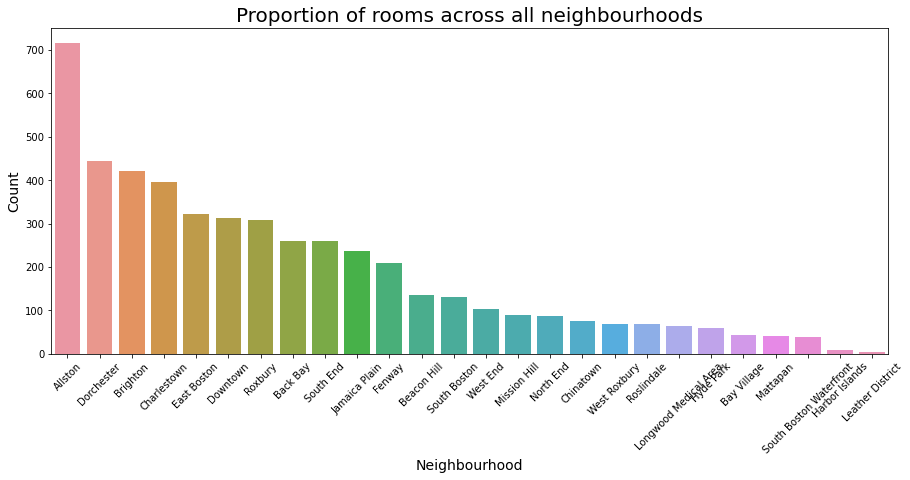

In [17]:
# popular neighbourhood
fig =plt.figure(figsize=(15,6))

sns.countplot(data =listings, x="neighbourhood_cleansed", 
              order = listings['neighbourhood_cleansed'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Proportion of rooms across all neighbourhoods', fontsize=20)
plt.xlabel('Neighbourhood', fontsize=14)
plt.ylabel('Count', fontsize=14);

In [18]:
listings['neighbourhood_cleansed'].value_counts().index

Index(['Allston', 'Dorchester', 'Brighton', 'Charlestown', 'East Boston',
       'Downtown', 'Roxbury', 'Back Bay', 'South End', 'Jamaica Plain',
       'Fenway', 'Beacon Hill', 'South Boston', 'West End', 'Mission Hill',
       'North End', 'Chinatown', 'West Roxbury', 'Roslindale',
       'Longwood Medical Area', 'Hyde Park', 'Bay Village', 'Mattapan',
       'South Boston Waterfront', 'Harbor Islands', 'Leather District'],
      dtype='object')

The top 1 neighborhood that has the most Airbnb rooms is Allston, which has more than 700 rooms, followed by Dorchester, Brighton, Charlestown, and East Boston. 

**Q2:Are the Airbnb rooms expensive? How much will it cost?**

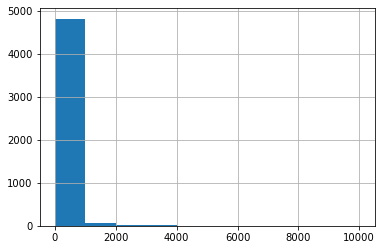

In [19]:
listings.price.hist(figsize=(6,4));

In [20]:
# price is left skewed, 
print(listings['price'].median(), "\n",
round(listings['price'].mean(), 2), "\n",
round(listings['price'].quantile(.95),2),"\n",
round(listings['price'].quantile(.98),2))

188.0 
 251.84 
 611.0 
 949.76


98% of the romm pirce is less than 1000, and around 95% less than 600. 

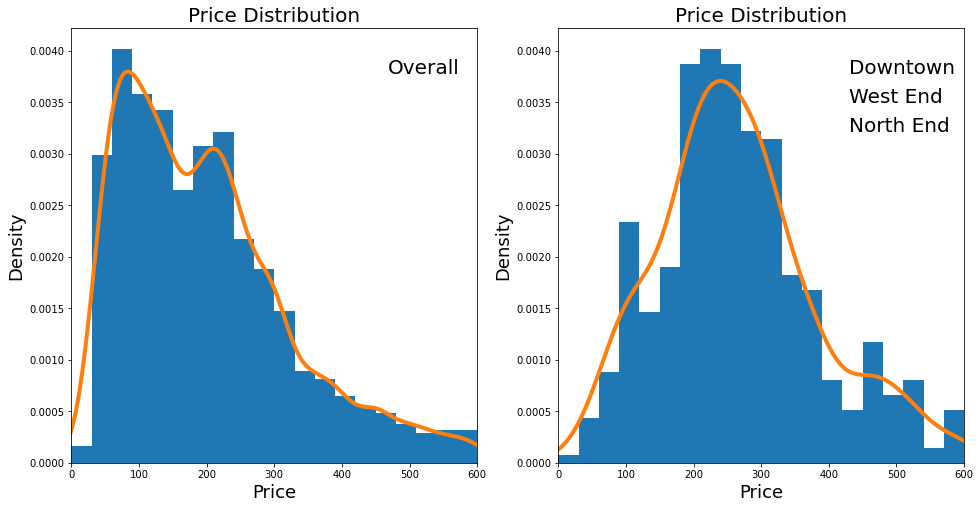

In [21]:
#price distribution less than 600

plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
listings[listings['price']<= 600]['price'].hist( bins=20, density=True)
plt.xlabel('Price', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.title('Price Distribution', fontsize=20)
listings[listings['price']<= 600]['price'].plot( kind ='kde', linewidth=4)
plt.figtext(0.4, 0.8, 'Overall', fontsize=20)
plt.xlim([0, 600])

plt.subplot(1,2,2)
listings[(listings['price']<= 600) & ((listings['neighbourhood_cleansed']== 'Downtown') | 
         (listings['neighbourhood_cleansed']== 'West End') |
         (listings['neighbourhood_cleansed']== 'North End'))]['price'].hist( bins=20, density=True)
plt.xlabel('Price', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.title('Price Distribution', fontsize=20)
listings[(listings['price']<= 600) & ((listings['neighbourhood_cleansed']== 'Downtown') |
         (listings['neighbourhood_cleansed']== 'West End') |
         (listings['neighbourhood_cleansed']== 'North End'))]['price'].plot(kind ='kde', linewidth=4)
plt.figtext(0.8, 0.8, 'Downtown', fontsize=20)
plt.figtext(0.8, 0.75, 'West End', fontsize=20)
plt.figtext(0.8, 0.7, 'North End', fontsize=20)
plt.xlim([0, 600]);

More than half of the rooms range from 50 to 300 dollars per night.. While in the three central neighborhoods (right) where the attractions are mainly located, the price goes up and ranges from 100 to 400 dollars per night.

#### Since the price may higher with more accommodates or vary within different room types. I would like to plot the price with accommodates and room types.

In [22]:
# accommodates
listings.accommodates.unique()

array([ 1,  5,  2,  8,  4,  6,  3,  7,  9, 12, 10, 16, 13, 15, 14,  0, 11],
      dtype=int64)

In [23]:
# drop accommodate equeal 0
listings[listings['accommodates'] == 0].index

Int64Index([1873], dtype='int64')

In [24]:
listings = listings.drop(index=1873)

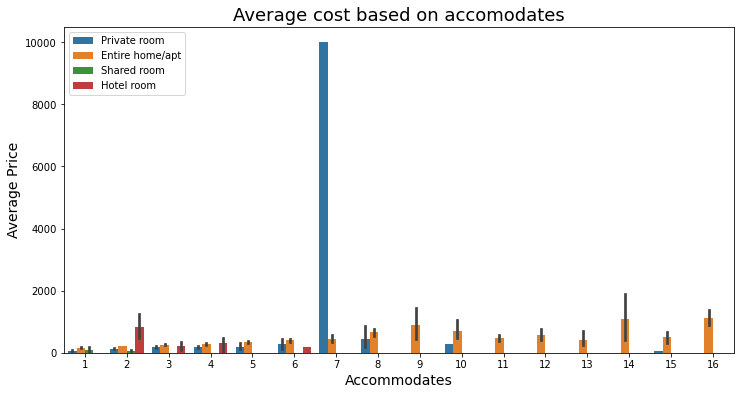

In [25]:
# average price for different accomodate for different room type
fig = plt.figure(figsize=(12,6))
sns.barplot(data =listings, x='accommodates', y ='price', hue="room_type");
plt.title('Average cost based on accomodates', fontsize=18)
plt.legend(loc='upper left')
plt.xlabel('Accommodates', fontsize=14)
plt.ylabel('Average Price', fontsize=14);

In [26]:
# find and remove the  outliner
listings[(listings['accommodates']==7) & (listings['room_type']=='Private room')]

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
191,6838488.0,https://www.airbnb.com/rooms/6838488,2.022060e+13,6/13/22,Beautiful Townhouse Unit #2 nr Harvard U. w/ pk,Enjoy a stay at one of Boston's best vacation ...,"Lovely, peaceful residential neighborhood with...",https://a0.muscache.com/pictures/6cf132c6-58a0...,14785487,https://www.airbnb.com/users/show/14785487,...,4.59,4.79,4.34,NaN,f,7,4,3,0,0.43


In [27]:
listings = listings.drop(index=191)

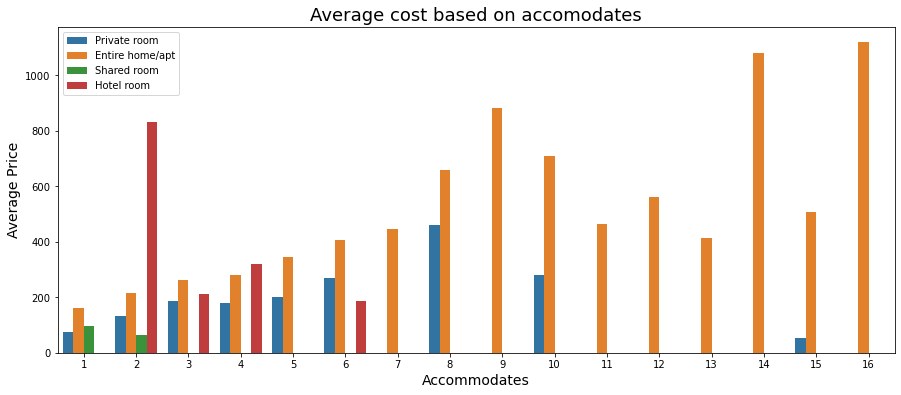

In [28]:
# after remove the outlier
fig = plt.figure(figsize=(15,6))
sns.barplot(data =listings, x='accommodates', y ='price', hue="room_type", ci=None)
plt.title('Average cost based on accomodates', fontsize=18)
plt.xlabel('Accommodates', fontsize=14)
plt.ylabel('Average Price', fontsize=14);
plt.legend(loc='upper left');

In [29]:
# price per person

(listings.price/listings.accommodates).mean()

81.21999431030986

It seems the average cost of private room is always lower than Entire home regardless of the number of accommodates. Hotel is extremely expensive for a two-person room, and the price become similar or even cheaper with more people when compared that with other room types. The overall average cost per person per night is around $80 per night per person

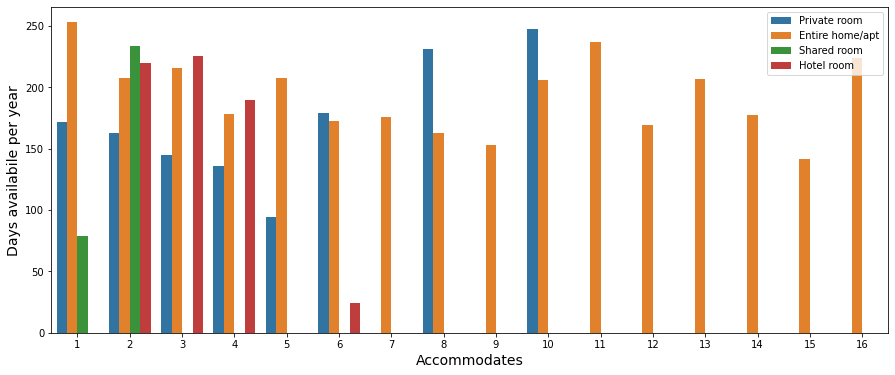

In [30]:
# availability
fig3 = plt.figure(figsize=(15,6))
sns.barplot(data =listings, x='accommodates', y ='availability_365', hue="room_type", ci=None)
# plt.title('Average cost based on accomodates', fontsize=18)
plt.xlabel('Accommodates', fontsize=14)
plt.ylabel('Days availabile per year', fontsize=14)
plt.legend(loc='upper right');

**Q3:What are the most popular amenities inside the rooms?**

In [31]:
# amenities analysis
listings_amenities = listings[['id', 'amenities']]
listings_amenities.head()

,id,amenities
0,9569407.0,"[""Long term stays allowed"", ""Essentials"", ""Sha..."
1,31650137.0,"[""Kitchen"", ""Long term stays allowed"", ""Coffee..."
2,1724900.0,"[""Kitchen"", ""Long term stays allowed"", ""Coffee..."
3,1732804.0,"[""Kitchen"", ""Long term stays allowed"", ""Coffee..."
4,1810172.0,"[""Kitchen"", ""Long term stays allowed"", ""Bathtu..."


In [32]:
# get dummy values for amenities 
# count ids for each amenity

def amenities(x): 
    """
    returns  1 if the string is included the  list else return 0
    
    input: 
        list of strings
    output:
        0 or 1
    """
    x = str(x).lower()
    
    if col.lower() in x:
        return 1
    else:
        return 0
            
for col in popular_amenitie_modified:
    listings_amenities[col]=listings_amenities['amenities'].apply(amenities)
    
listings_amenities.head()

,id,amenities,Smoke alarm,Dryer,Wifi,TV,Essentials,Kitchen,Hangers,Iron,...,Bed,Cooking basics,Fire extinguisher,Oven,Stove,Cable,Dishwasher,Lock,Balcony,Patio
0,9569407.0,"[""Long term stays allowed"", ""Essentials"", ""Sha...",1,1,1,0,1,0,1,1,...,1,0,0,0,0,0,0,1,0,0
1,31650137.0,"[""Kitchen"", ""Long term stays allowed"", ""Coffee...",1,1,1,0,1,1,1,1,...,1,1,1,1,1,0,0,1,0,0
2,1724900.0,"[""Kitchen"", ""Long term stays allowed"", ""Coffee...",1,1,1,1,1,1,1,1,...,1,1,0,1,1,0,0,0,0,0
3,1732804.0,"[""Kitchen"", ""Long term stays allowed"", ""Coffee...",1,1,1,0,1,1,1,1,...,0,0,1,1,1,0,1,1,1,1
4,1810172.0,"[""Kitchen"", ""Long term stays allowed"", ""Bathtu...",1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,0,0,0


Using the previous created amenity list, I convert each amentites description to dummy data, which is easy for analysis.

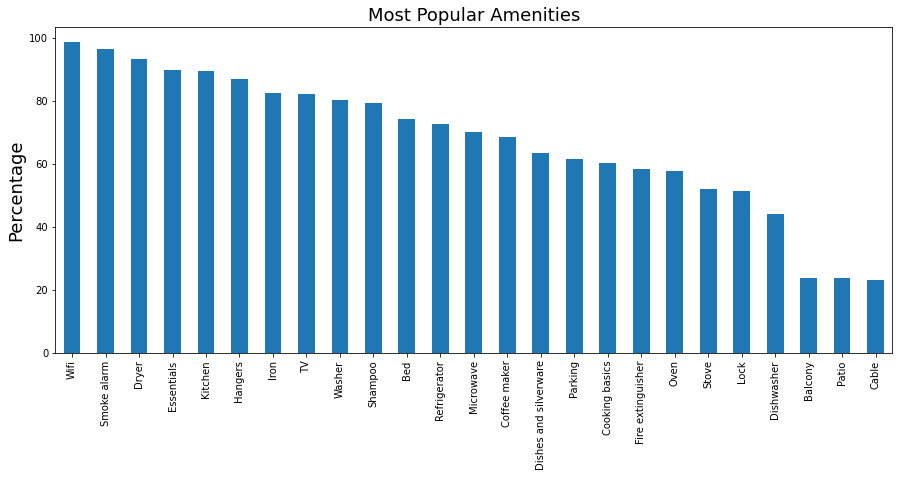

In [33]:
#plot top amenities 
fig0 = plt.figure(figsize=(15,6))
(listings_amenities.sum(axis =0)[2:32]/listings_amenities.shape[0] *100).sort_values(ascending=False, inplace=False).plot(kind='bar');
plt.title('Most Popular Amenities', fontsize=18)
plt.ylabel('Percentage', fontsize=18);

Nowadays, Wi-Fi, essentials, as well as smoke alarms are must-have amenities as expected. Others, like Dryer/Washer, cooking essentials, and kitchen stuff are also important amenities to facilitate the guests’ stay.

**Q4: Are the guests satisfied with the rooms?**

In [34]:
# top hosts with most reviews

listings.number_of_reviews.mean(), listings.review_scores_rating.mean()

(46.59314425627423, 4.692636922254865)

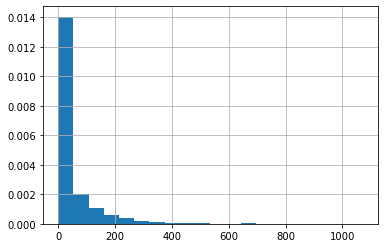

In [35]:
listings.number_of_reviews.hist( bins=20, density=True);

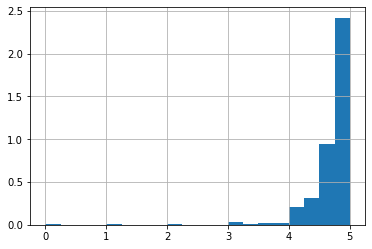

In [36]:
listings.review_scores_rating.hist(bins=20, density=True);

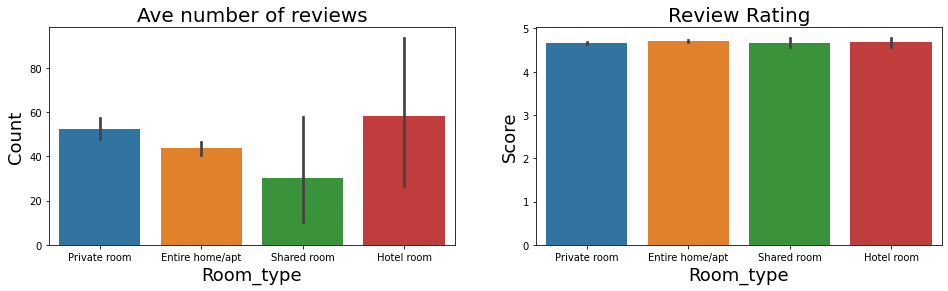

In [37]:
plt.figure(figsize=(16,4))

plt.subplot(1,2,1)
sns.barplot(data =listings, x="room_type", y ='number_of_reviews')
plt.xlabel('Room_type', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.title('Ave number of reviews', fontsize=20)


plt.subplot(1,2,2)
sns.barplot(data =listings, x="room_type", y ='review_scores_rating')
plt.xlabel('Room_type', fontsize=18)
plt.ylabel('Score', fontsize=18)
plt.title('Review Rating', fontsize=20);

Although hotel room have more number of reviews but the average rating score are similar across board.

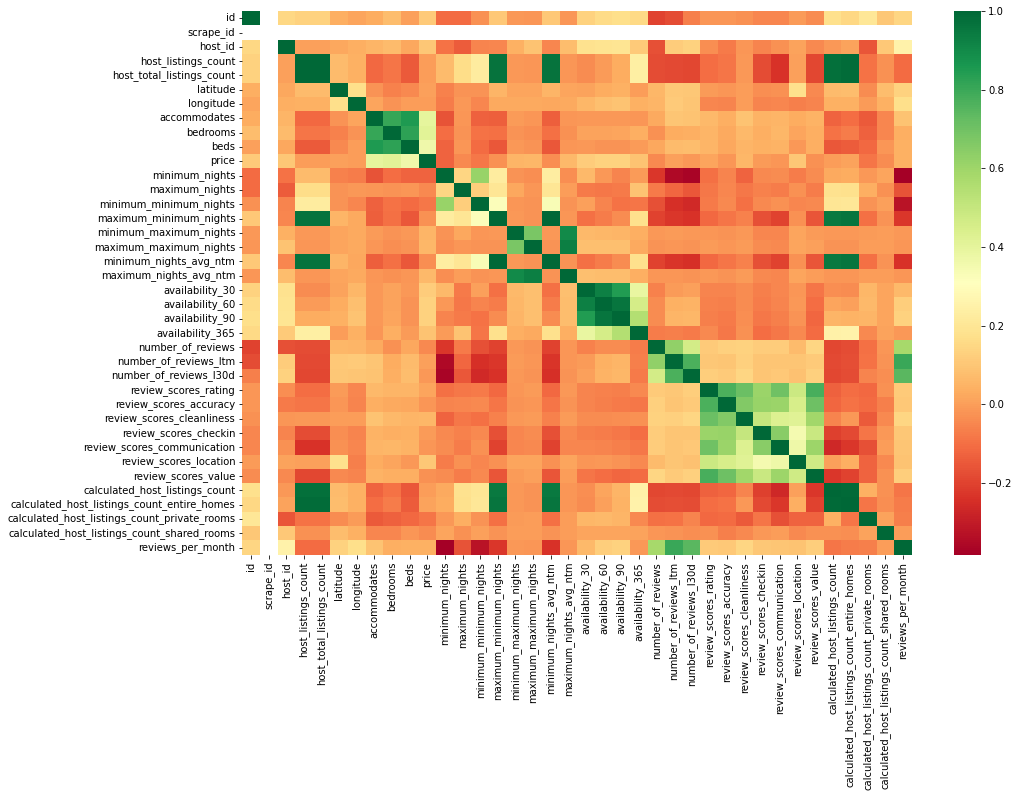

In [38]:
# possible correlations
plt.figure(figsize=(15,10))
sns.heatmap(listings.corr(), cmap='RdYlGn');

Most of the features are not colsely associated with the price. 

### Modeling 

**Dataset process:**
* Drop non-relevant columns
* Drop rows with missing values
* Convert categorical variable to numbers

In [39]:
#drop hotel room and shared room
listings_cleaned= listings[(listings['room_type']=='Private room') |(listings['room_type']=='Entire home/apt')]

In [40]:
# drop irrelevant columns
drop_list = ['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description', 'neighborhood_overview',
             'picture_url', 'host_id', 'host_url', 'host_name','host_response_time', 'host_verifications', 'host_since', 'host_location', 'host_about',
             'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'neighbourhood_cleansed','host_listings_count', 'host_total_listings_count',
             'neighbourhood', 'property_type',  'bathrooms_text', 'calendar_last_scraped',  'first_review', 'last_review','amenities']

listings_cleaned = listings_cleaned.drop(columns = drop_list)

In [41]:
listings_cleaned.head()

,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,latitude,longitude,room_type,accommodates,bedrooms,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,90%,22%,f,t,t,42.33588,-71.18811,Private room,1,1.0,...,5.00,4.92,4.77,NaN,f,2,0,2,0,0.17
1,100%,100%,t,t,t,42.40645,-71.05180,Private room,1,1.0,...,5.00,4.84,4.92,NaN,t,3,0,3,0,3.60
2,50%,38%,f,t,f,42.28447,-71.13301,Entire home/apt,5,2.0,...,4.79,4.56,4.65,NaN,f,2,2,0,0,0.42
3,100%,100%,t,t,t,42.29009,-71.05762,Private room,2,1.0,...,5.00,4.66,4.79,STR-398497,f,1,0,1,0,1.39
4,100%,88%,f,t,t,42.28127,-71.13304,Private room,2,1.0,...,4.98,4.68,4.78,NaN,f,2,0,2,0,0.40


In [42]:
# listings_cleaned.isnull().sum()

In [43]:
#convert categorical value to numbers
col_list = ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'instant_bookable']
for col in col_list: 
    listings_cleaned[col] = listings_cleaned[col].apply(lambda x: 1 if x is 't' else 0)
    
# convert license    
listings_cleaned['license'] = listings_cleaned['license'].apply(lambda x: 0 if x is np.nan else 1)

In [44]:
# convert categorical to numbers
listings_cleaned = pd.get_dummies(listings_cleaned, columns=['room_type'], prefix='', prefix_sep='')

In [45]:
listings_cleaned.head()

,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,latitude,longitude,accommodates,bedrooms,beds,...,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,Entire home/apt,Private room
0,90%,22%,0,1,1,42.33588,-71.18811,1,1.0,1.0,...,4.77,0,0,2,0,2,0,0.17,0,1
1,100%,100%,1,1,1,42.40645,-71.05180,1,1.0,1.0,...,4.92,0,1,3,0,3,0,3.60,0,1
2,50%,38%,0,1,0,42.28447,-71.13301,5,2.0,2.0,...,4.65,0,0,2,2,0,0,0.42,1,0
3,100%,100%,1,1,1,42.29009,-71.05762,2,1.0,1.0,...,4.79,1,0,1,0,1,0,1.39,0,1
4,100%,88%,0,1,1,42.28127,-71.13304,2,1.0,1.0,...,4.78,0,0,2,0,2,0,0.40,0,1


In [46]:
#Spearman Correalation Heatmap
# plt.figure(figsize=(20,15))
# corr = listings_cleaned.corr(method = 'spearman')
# sns.heatmap(round(corr,2), annot = True,cmap="RdYlGn")
# plt.show()

In [47]:
#correlation with price 
listings_cleaned.corr(method = 'spearman')['price'].sort_values(ascending =False)[1:]

Entire home/apt                                 0.635124
accommodates                                    0.598979
bedrooms                                        0.545484
calculated_host_listings_count_entire_homes     0.491200
beds                                            0.483814
availability_60                                 0.292668
availability_90                                 0.281860
availability_30                                 0.278689
review_scores_location                          0.261318
instant_bookable                                0.217149
availability_365                                0.208230
license                                         0.206518
calculated_host_listings_count                  0.202888
reviews_per_month                               0.202468
review_scores_cleanliness                       0.147810
host_identity_verified                          0.145991
longitude                                       0.142185
latitude                       

In [48]:
# only keep coclumns highly associated with price, absolute value > 0.1

listings_cleaned = listings_cleaned.drop(columns = ['number_of_reviews_l30d', 'number_of_reviews_ltm', 'review_scores_rating',
                                         'review_scores_accuracy', 'review_scores_rating', 'review_scores_accuracy',
                                         'review_scores_communication', 'host_is_superhost', 'host_has_profile_pic', 
                                         'review_scores_checkin', 'calculated_host_listings_count_shared_rooms', 'maximum_maximum_nights',
                                         'maximum_nights', 'maximum_nights_avg_ntm', 'number_of_reviews', 'maximum_minimum_nights',
                                         'minimum_maximum_nights', 'review_scores_value'])


In [49]:
#clean up null value to prepare data for training
listings_cleaned.isnull().sum()/listings_cleaned.shape[0] *100

host_response_rate                              11.626469
host_acceptance_rate                            11.255411
host_identity_verified                           0.000000
latitude                                         0.000000
longitude                                        0.000000
accommodates                                     0.000000
bedrooms                                        12.079984
beds                                             1.607916
price                                            0.000000
minimum_nights                                   0.000000
minimum_minimum_nights                           0.000000
minimum_nights_avg_ntm                           0.000000
has_availability                                 0.000000
availability_30                                  0.000000
availability_60                                  0.000000
availability_90                                  0.000000
availability_365                                 0.000000
review_scores_

In [50]:
# drop columns have too much missing value, beds is so import that I keep it and drop the nnull value rows
listings_cleaned=listings_cleaned.drop(columns =['host_response_rate', 'host_acceptance_rate', 'bedrooms',
                                                'review_scores_cleanliness', 'review_scores_location','reviews_per_month', 'has_availability'])
listings_cleaned=listings_cleaned.dropna()

In [51]:
listings_cleaned.head()

,host_identity_verified,latitude,longitude,accommodates,beds,price,minimum_nights,minimum_minimum_nights,minimum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,Entire home/apt,Private room
0,1,42.33588,-71.18811,1,1.0,60.0,91,91.0,91.0,0,0,0,255,0,0,2,0,2,0,1
1,1,42.40645,-71.05180,1,1.0,104.0,2,2.0,2.0,25,55,85,85,0,1,3,0,3,0,1
2,0,42.28447,-71.13301,5,2.0,184.0,29,29.0,29.0,11,11,11,174,0,0,2,2,0,1,0
3,1,42.29009,-71.05762,2,1.0,69.0,1,1.0,1.0,9,21,50,296,1,0,1,0,1,0,1
4,1,42.28127,-71.13304,2,1.0,69.0,29,29.0,29.0,14,24,41,296,0,0,2,0,2,0,1


In [52]:
listings_cleaned.shape

(4773, 20)

The cleaned dataset contains 4773 rows and 20 features.

In [53]:
#correlation with price 
listings_cleaned.corr(method = 'spearman')['price'].sort_values(ascending =False)[1:]

Entire home/apt                                 0.628330
accommodates                                    0.591525
calculated_host_listings_count_entire_homes     0.491445
beds                                            0.483814
availability_60                                 0.290456
availability_90                                 0.280321
availability_30                                 0.276769
instant_bookable                                0.214412
calculated_host_listings_count                  0.210850
availability_365                                0.209950
license                                         0.198968
host_identity_verified                          0.149729
longitude                                       0.138207
latitude                                        0.135986
minimum_nights_avg_ntm                         -0.108576
minimum_nights                                 -0.204477
minimum_minimum_nights                         -0.212523
calculated_host_listings_count_

**Q5:What are the predictors of price for Boston AirBnB’s?**

In [54]:
# split dataset
X = listings_cleaned.drop(columns = ['price'])
y = listings_cleaned['price']


In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [56]:
# Linear Regression Model
lm_model = LinearRegression(normalize=True)    
lm_model.fit(X_train, y_train) 


LinearRegression(normalize=True)

In [57]:
coef_table = pd.DataFrame(list(X_train.columns), columns=['Features']).copy()
coef_table.insert(len(coef_table.columns),"Coefs",lm_model.coef_.transpose())
coef_table.sort_values(['Coefs'], ascending=False)


,Features,Coefs
1,latitude,85.081651
3,accommodates,37.707531
4,beds,36.524509
13,instant_bookable,33.894929
17,Entire home/apt,32.914522
12,license,28.890504
14,calculated_host_listings_count,25.479249
0,host_identity_verified,13.816096
9,availability_60,2.347404
6,minimum_minimum_nights,0.072166


Features that highly postively associated with price:
* latitude
* accommodates
* beds
* Entire home/apt

Features that highly negatively associated with price:
* longitude
* Private room

In [58]:
# View the intercept
lm_model.intercept_

-27258.239571338945

In [59]:
def predict_score(model):
    """
    return the accuracy score of the test data for initialized model 
    input:
       initialized model 
    output:
        float
    """
    pred = model.predict(X_test)
    
    # Calculate the absolute errors
    errors = abs(pred - y_test)
    
    # Calculate mean absolute percentage error
    mean_APE = 100 * (errors / y_test)
    accuracy = 100 - np.mean(mean_APE)
    
    return round(accuracy, 4)

In [60]:
# Train data with Random Forest Regressor
rf = RandomForestRegressor(random_state = 42)

rf.fit(X_train, y_train)
print(f'Accuracy of RandomForestRegressor on training set: {round(rf.score(X_train, y_train)*100,2)}%.')
print(f'Prediction Accuracy: {predict_score(rf)}%')

Accuracy of RandomForestRegressor on training set: 90.13%.
Prediction Accuracy: 60.9241%


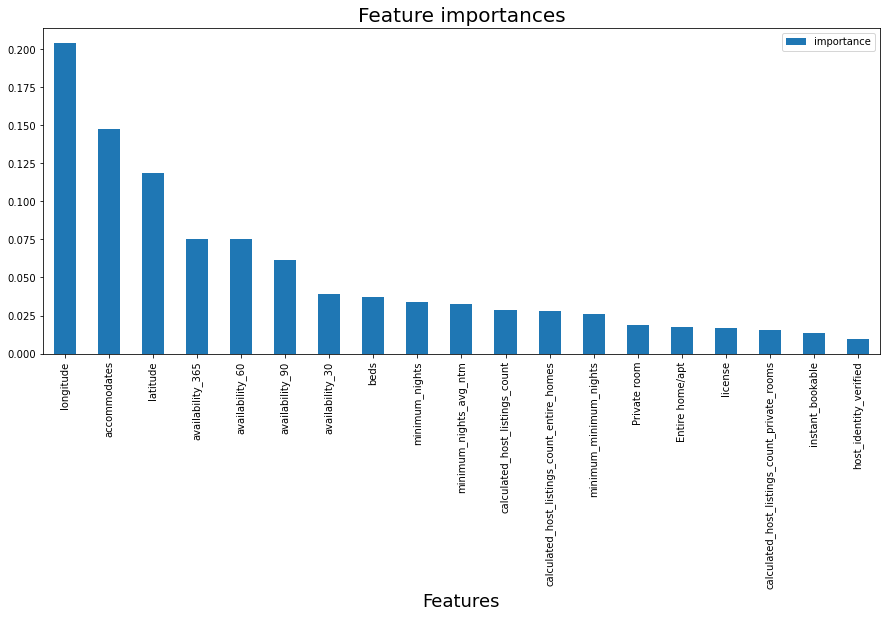

In [61]:
sorted(rf.feature_importances_)
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)


feature_importances.plot.bar(figsize = (15, 6))
plt.xlabel('Features', fontsize=18)

plt.title('Feature importances', fontsize=20);

Top features that have influence on price:
* latitude
* longitude
* accommodate
* availability_365
* availability_60
*  availability_90
* availability_30
* beds

# Conclusion <a class="anchor" id="4"></a>

From my analysis, I have some interesting findings that could be helpful for your next trip.

* Location: 
You could choose live in central area with a little bit higher in rental price but close to attractions, or choose edge area where the same rooms could be one hundred dollars cheaper. 

* Room type:
You probably want to live in private or entire home/apt for there are more choices to choose. 

* Cost per night 
Roughly, no matter how many people will travel togehter, the avrage cost per person per nihgt will be around 100 dollars.

Fianlly, we explore the featrues that affect the price.
Based on the previous investigation, we conclude the features listed below have more impact on predicting the price of Boston Airbnb listings:

* latitude
* longitude
* accommodates
* availability_365
* availability_60
* availability_90
* availability_30
* beds